In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好.
# 在Windows需要单独安装torchvision包，在命令行运行pip install torchvision即可
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutil


import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# 定义超参数
image_size = 28 #图像尺寸大小
input_dim = 100 #输入给生成器的向量维度，维度越大可以增加生成器输出样本的多样性
num_channels = 1# 图像的通道数
num_features = 64 #生成器中间的卷积核数量
batch_size = 64 #批次大小

# 如果系统中存在着GPU，我们将用GPU来完成张量的计算
use_cuda = torch.cuda.is_available() #定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor，在加载数据的时候，就可以对图像做预处理
                            download=True) #当找不到文件的时候，自动下载

# 加载测试数据集
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

'''我们希望将测试数据分成两部分，一部分作为校验数据，一部分作为测试数据。
校验数据用于检测模型是否过拟合，并调整参数，测试数据检验整个模型的工作'''


# 首先，我们定义下标数组indices，它相当于对所有test_dataset中数据的编码
# 然后定义下标indices_val来表示校验集数据的那些下标，indices_test表示测试集的下标
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

# 根据这些下标，构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据两个采样器来定义加载器，注意将sampler_val和sampler_test分别赋值给了validation_loader和test_loader
validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val
                                               )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          sampler = sampler_test
                                         )


D:\Anaconda\envs\test\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
#生成器模型定义

class ModelG(nn.Module):
    def __init__(self):
        super(ModelG,self).__init__()
        self.model=nn.Sequential() #model为一个内嵌的序列化的神经网络模型
        
        # 利用add_module增加一个反卷积层，输入为input_dim维，输出为2*num_features维，窗口大小为5，padding是0
        # 输入图像大小为1，输出图像大小为W'=(W-1)S-2P+K+P'=(1-1)*2-2*0+5+0=3, 5*5
        self.model.add_module('deconv1',nn.ConvTranspose2d(input_dim, num_features*2, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm1',nn.BatchNorm2d(num_features*2))
        # 增加sigmoid层
        self.model.add_module('relu1',nn.ReLU())
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口5，padding=0
        # 输入图像大小为5，输出图像大小为W'=(W-1)S-2P+K+P'=(5-1)*2-2*0+5+0=13, 13*13
        self.model.add_module('deconv2',nn.ConvTranspose2d(num_features*2, num_features, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm2',nn.BatchNorm2d(num_features))
        # 增加sigmoid层
        self.model.add_module('relu2',nn.ReLU())

        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口4，padding=0
        # 输入图像大小为13，输出图像大小为W'=(W-1)S-2P+K+P'=(13-1)*2-2*0+4+0=28, 28*28
        self.model.add_module('deconv3',nn.ConvTranspose2d(num_features, num_channels, 4, 2, 0,bias=False))
        #self.model.add_module('tanh',nn.Tanh())
        self.model.add_module('sigmoid3',nn.Sigmoid())
    def forward(self,input):
        output = input
        
        #遍历网络的所有层，一层层输出信息
        for name, module in self.model.named_children():
            output = module(output)
        #输出一张28*28的图像
        return(output)


def weight_init(m):
    #模型参数初始化．
    #默认的初始化参数卷积核的权重是均值大概为0，方差在10^{-2}. BatchNorm层的权重均值是大约0.5，方差在0.2左右
    #使用如下初始化方式可以，可以让方差更小，使得收敛更快
    class_name=m.__class__.__name__
    if class_name.find('conv')!=-1:
        m.weight.data.normal_(0,0.02)
    if class_name.find('norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
def make_show(img):
    # 将张量变成可以显示的图像
    img = img.data.expand(batch_size, 3, image_size, image_size)
    return img
def imshow(inp, title=None, ax=None):
    # 在屏幕上绘制图像
    """Imshow for Tensor."""
    if inp.size()[0] > 1:
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        inp = inp[0].numpy()
    mvalue = np.amin(inp)
    maxvalue = np.amax(inp)
    if maxvalue > mvalue:
        inp = (inp - mvalue)/(maxvalue - mvalue)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)


In [6]:
# 定义待迁移的网络框架，所有的神经网络模块包括：Conv2d、MaxPool2d，Linear等模块都不需要重新定义，会自动加载
# 但是网络的forward功能没有办法自动实现，需要重写。
# 一般的，加载网络只加载网络的属性，不加载方法
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x, dim = 1) #log_softmax可以理解为概率对数值
        return x
    def retrieve_features(self, x):
        #该函数专门用于提取卷积神经网络的特征图的功能，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) #完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层pooling
        feature_map2 = F.relu(self.conv2(x)) #第二层卷积，两层特征图都存储到了feature_map1, feature_map2中
        return (feature_map1, feature_map2)
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素


In [7]:
netR = torch.load('minst_conv_checkpoint') #读取硬盘上的minst_conv_checkpoint文件
netR = netR.cuda() if use_cuda else netR #加载到GPU中
for para in netR.parameters():
    para.requires_grad = False #将识别器的权重设置为固定值

D:\Anaconda\envs\test\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\Anaconda\envs\test\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\Anaconda\envs\test\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `t

In [10]:
#开始训练

print('Initialized!')

netG = ModelG() #新建一个生成器
netG = netG.cuda() if use_cuda else netG #加载到GPU上
netG.apply(weight_init) #初始化参数

criterion = nn.CrossEntropyLoss() #用交叉熵作为损失函数
optimizer = optim.SGD(netG.parameters(), lr=0.0001, momentum=0.9) #定义优化器

#随机选择batch_size个数字，用他们来生成数字图像
samples = np.random.choice(10, batch_size)
samples = torch.from_numpy(samples).type(dtype).requires_grad_(False)
step=0
num_epochs = 20 #总训练周期
statistics = [] #数据记载器
for epoch in range(num_epochs):
    train_loss = []
    train_rights = []
    
    # 加载数据
    for batch_idx, (data, target) in enumerate(train_loader):
        # 注意图像和标签互换了
        target, data = data.clone().detach().requires_grad_(True), target.clone().detach() #data为一批标签，target为一批图像
        if use_cuda:
            target, data = target.cuda(), data.cuda()
        # 复制标签变量放到了label中
        label = data.clone()
        data = data.type(dtype)
        # 改变张量形状以适用于生成器网络
        data = data.resize(data.size()[0], 1, 1, 1)
        data = data.expand(data.size()[0], input_dim, 1, 1)

        netG.train() # 给网络模型做标记，标志说模型正在训练集上训练，
        netR.train() #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
        output1 = netG(data) #神经网络完成一次前馈的计算过程，得到预测输出output
        output = netR(output1) #用识别器网络来做分类
        loss = criterion(output, label) #将output与标签target比较，计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降算法
        step += 1
        if use_cuda:
            loss = loss.cpu()
        train_loss.append(loss.data.numpy())
        right = rightness(output, label) #计算准确率所需数值，返回数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器train_rights中
        
        if step % 100 == 0: #每间隔100个batch执行一次打印等操作
            
            netG.eval() # 给网络模型做标记，标志说模型正在校验集上运行，
            netR.eval() #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
            val_loss = [] #记录校验数据集准确率的容器
            val_rights = []
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            for (data, target) in validation_loader:
                # 注意target是图像，data是标签
                target, data = data.clone().detach().requires_grad_(True), target.clone().detach()
                if use_cuda:
                    target, data = target.cuda(), data.cuda()
                label = data.clone()
                data = data.type(dtype)
                #改变Tensor大小以适应生成网络
                data = data.resize(data.size()[0], 1, 1, 1)
                data = data.expand(data.size()[0], input_dim, 1, 1)
                
                output1 = netG(data) #神经网络完成一次前馈的计算过程，得到预测输出output
                output = netR(output1) #利用识别器来识别
                loss = criterion(output, label) #将output与标签target比较，计算误差
                if use_cuda:
                    loss = loss.cpu()
                val_loss.append(loss.data.numpy())
                right = rightness(output, label) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_rights.append(right)
            # 分别计算在目前已经计算过的测试数据集，以及全部校验集上模型的表现：分类准确率
            #train_r为一个二元组，分别记录目前已经经历过的所有训练集中分类正确的数量和该集合中总的样本数，
            #train_r[0]/train_r[1]就是训练集的分类准确度，同样，val_r[0]/val_r[1]就是校验集上的分类准确度
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            print(('训练周期: {} [{}/{} ({:.0f}%)]\t训练数据Loss: {:.6f},正确率: {:.2f}%\t校验数据Loss:' +
                  '{:.6f},正确率:{:.2f}%').format(epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(train_loss), 
                                               100. * train_r[0].numpy() / train_r[1], 
                                               np.mean(val_loss), 
                                               100. * val_r[0].numpy() / val_r[1]))
            #记录中间的数据
            statistics.append({'loss':np.mean(train_loss),'train': 100. * train_r[0] / train_r[1],
                               'valid':100. * val_r[0] / val_r[1]})
            
    # 产生一组图像保存到temp1文件夹下（需要事先建立好该文件夹），检测生成器当前的效果
    samples.resize_(batch_size,1,1,1)
    samples = samples.expand(batch_size, input_dim, 1, 1)
    samples = samples.cuda() if use_cuda else samples
    fake_u=netG(samples)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)
    vutil.save_image(img,'识别器模型2/fake%s.png'% (epoch))

Initialized!
训练周期: 0 [6336/60000 (11%)]	训练数据Loss: 1.958849,正确率: 35.98%	校验数据Loss:1.011776,正确率:61.62%
训练周期: 0 [12736/60000 (21%)]	训练数据Loss: 1.557148,正确率: 47.05%	校验数据Loss:0.847137,正确率:80.98%
训练周期: 0 [19136/60000 (32%)]	训练数据Loss: 1.341953,正确率: 53.80%	校验数据Loss:0.638759,正确率:80.98%
训练周期: 0 [25536/60000 (43%)]	训练数据Loss: 1.222474,正确率: 57.46%	校验数据Loss:0.557037,正确率:79.98%
训练周期: 0 [31936/60000 (53%)]	训练数据Loss: 1.124668,正确率: 60.64%	校验数据Loss:0.540577,正确率:80.52%
训练周期: 0 [38336/60000 (64%)]	训练数据Loss: 1.056697,正确率: 62.76%	校验数据Loss:0.376052,正确率:100.00%
训练周期: 0 [44736/60000 (75%)]	训练数据Loss: 1.013759,正确率: 63.98%	校验数据Loss:0.395819,正确率:90.22%
训练周期: 0 [51136/60000 (85%)]	训练数据Loss: 0.969206,正确率: 65.47%	校验数据Loss:0.392561,正确率:79.98%
训练周期: 0 [57536/60000 (96%)]	训练数据Loss: 0.929499,正确率: 66.72%	校验数据Loss:0.280596,正确率:89.76%
训练周期: 1 [3904/60000 (7%)]	训练数据Loss: 0.601098,正确率: 78.58%	校验数据Loss:0.301971,正确率:100.00%
训练周期: 1 [10304/60000 (17%)]	训练数据Loss: 0.582059,正确率: 78.67%	校验数据Loss:0.273176,正确率:100.00%
训练周期: 1 [16704/6000

训练周期: 10 [1216/60000 (2%)]	训练数据Loss: 0.085232,正确率: 99.45%	校验数据Loss:0.022065,正确率:100.00%
训练周期: 10 [7616/60000 (13%)]	训练数据Loss: 0.206582,正确率: 93.85%	校验数据Loss:0.030238,正确率:100.00%
训练周期: 10 [14016/60000 (23%)]	训练数据Loss: 0.173320,正确率: 95.09%	校验数据Loss:0.022185,正确率:100.00%
训练周期: 10 [20416/60000 (34%)]	训练数据Loss: 0.163286,正确率: 95.42%	校验数据Loss:0.020269,正确率:100.00%
训练周期: 10 [26816/60000 (45%)]	训练数据Loss: 0.171303,正确率: 95.15%	校验数据Loss:0.022173,正确率:100.00%
训练周期: 10 [33216/60000 (55%)]	训练数据Loss: 0.181870,正确率: 94.74%	校验数据Loss:0.026333,正确率:100.00%
训练周期: 10 [39616/60000 (66%)]	训练数据Loss: 0.185068,正确率: 94.63%	校验数据Loss:0.020362,正确率:100.00%
训练周期: 10 [46016/60000 (77%)]	训练数据Loss: 0.181878,正确率: 94.75%	校验数据Loss:0.019939,正确率:100.00%
训练周期: 10 [52416/60000 (87%)]	训练数据Loss: 0.187863,正确率: 94.43%	校验数据Loss:0.025563,正确率:100.00%
训练周期: 10 [58816/60000 (98%)]	训练数据Loss: 0.183773,正确率: 94.57%	校验数据Loss:0.019334,正确率:100.00%
训练周期: 11 [5184/60000 (9%)]	训练数据Loss: 0.236679,正确率: 93.71%	校验数据Loss:0.029036,正确率:100.00%
训练周期: 11 [11584

训练周期: 19 [49728/60000 (83%)]	训练数据Loss: 0.121177,正确率: 96.78%	校验数据Loss:0.010592,正确率:100.00%
训练周期: 19 [56128/60000 (93%)]	训练数据Loss: 0.117898,正确率: 96.89%	校验数据Loss:0.008585,正确率:100.00%


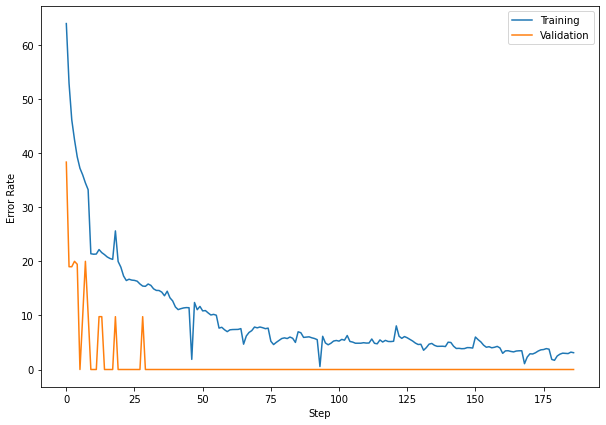

In [11]:
# 训练曲线
result1 = [100 - i['train'] for i in statistics]
result2 = [100 - i['valid'] for i in statistics]
plt.figure(figsize = (10, 7))
plt.plot(result1, label = 'Training')
plt.plot(result2, label = 'Validation')
plt.xlabel('Step')
plt.ylabel('Error Rate')
plt.legend()

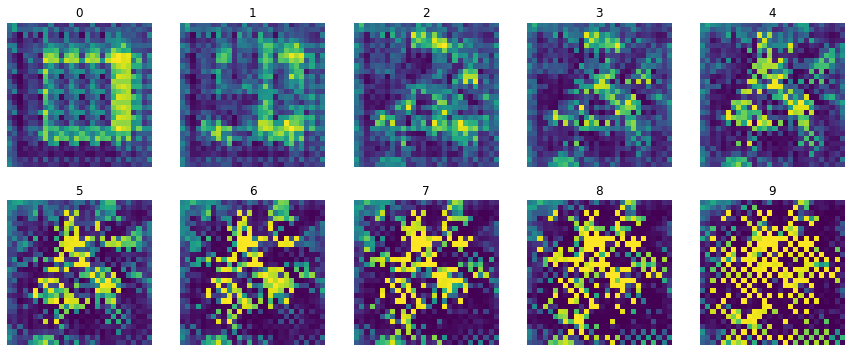

In [12]:
#绘制一批样本
samples = torch.Tensor([0,1,2,3,4,5,6,7,8,9])
samples = samples.type(dtype).clone()

sample_size = 10
samples.resize_(sample_size,1,1,1)
samples = samples.expand(sample_size, input_dim, 1, 1)
samples = samples.cuda() if use_cuda else samples
fake_u = netG(samples)
fake_u = fake_u.cpu() if use_cuda else fake_u
samples = samples.cpu() if use_cuda else samples
img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
#fig = plt.figure(figsize = (15, 6))
f, axarr = plt.subplots(2,5, sharex=True, figsize=(15,6))

for i in range(sample_size):
    axarr[i // 5, i % 5].axis('off')
    imshow(img[i].data, samples.data.numpy()[i][0,0,0].astype(int), axarr[i // 5, i % 5])
    
    


tensor([[9.]])


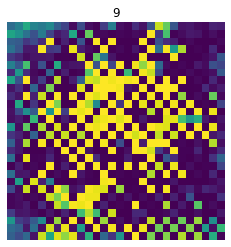

In [13]:
idx = 9
ax = plt.gca()
ax.axis('off')
imshow(fake_u[idx].data, 9, plt.gca())
print(samples[idx][0])

tensor([[7.]])


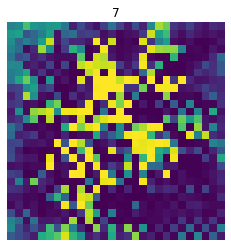

In [14]:
idx = 7
ax = plt.gca()
ax.axis('off')
imshow(fake_u[idx].data, 7, plt.gca())
print(samples[idx][0])

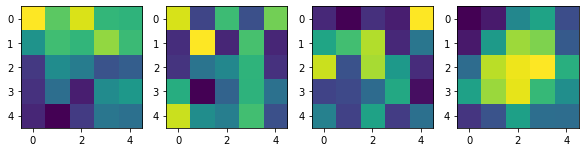

In [15]:
#提取第一层卷积层的卷积核
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    weight = netR.conv1.weight.cpu() if use_cuda else netR.conv1.weight
    plt.imshow(weight.data.numpy()[i,0,...])


tensor([7])


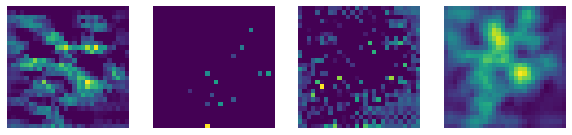

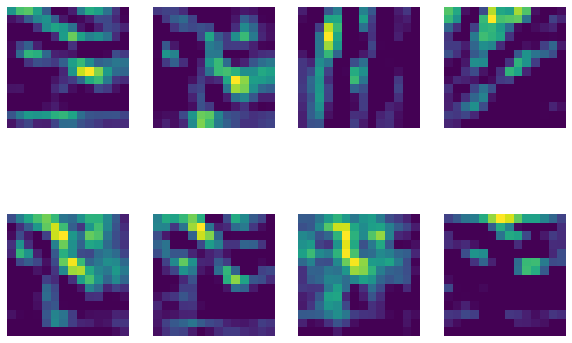

In [16]:
#调用net的retrieve_features方法可以抽取出喂入当前数据后吐出来的所有特征图（第一个卷积和第二个卷积层）

#首先定义读入的图片

#它是从test_dataset中提取第idx个批次的第0个图，其次unsqueeze的作用是在最前面添加一维，
#目的是为了让这个input_x的tensor是四维的，这样才能输入给net。补充的那一维表示batch。
input_x = fake_u[idx]
input_x = input_x.unsqueeze(0)
input_x = input_x.cuda() if use_cuda else input_x
output = netR(input_x)
_, prediction = torch.max(output, 1)
print(prediction)
feature_maps = netR.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图
feature_maps = (feature_maps[0].cpu(), feature_maps[1].cpu()) if use_cuda else feature_maps
plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())
#第二层有8个特征图，循环把它们打印出来
plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i,...].data.numpy())

In [17]:
batch = next(iter(test_loader))
indx = torch.nonzero(batch[1] == 3)
print(batch[1])
print(batch[1]==3)
data = batch[0][indx[0]]


tensor([1, 7, 6, 0, 6, 7, 1, 9, 1, 6, 9, 6, 5, 0, 1, 2, 6, 4, 6, 0, 7, 8, 1, 3,
        0, 6, 6, 6, 7, 3, 1, 7, 8, 8, 3, 1, 3, 7, 6, 0, 0, 4, 8, 5, 7, 6, 8, 4,
        4, 4, 3, 2, 0, 2, 0, 5, 6, 2, 1, 4, 4, 7, 6, 8])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,  True,
        False, False, False, False,  True, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False])


torch.Size([1, 1, 28, 28])


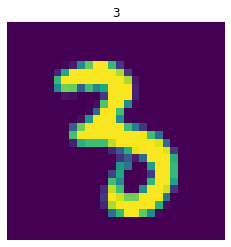

In [21]:
img = data.expand(1, 1, image_size, image_size)
print(img.size())
plt.axis('off')
imshow(img[0], 3, plt.gca())

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

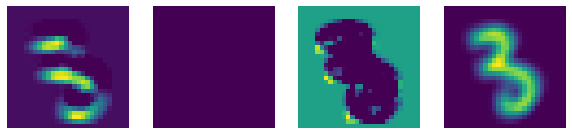

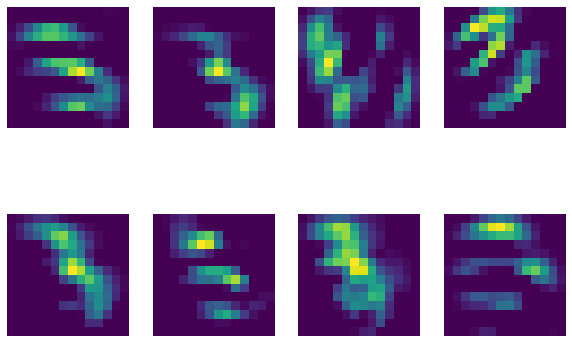

In [22]:
input_x = data.clone().detach().requires_grad_(True)
print(input_x)
input_x = input_x.cuda() if use_cuda else input_x
print(input_x)
output = netR(input_x)
print(output)
_, prediction = torch.max(output, 1)
print(_)
print(prediction)
feature_maps = netR.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图
feature_maps = (feature_maps[0].cpu(), feature_maps[1].cpu()) if use_cuda else feature_maps
plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i,...].data.numpy())

0123456789
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tensor([0])
tensor([1])
tensor([2])
tensor([3])
tensor([4])
tensor([5])
tensor([6])
tensor([7])
tensor([8])
tensor([9])


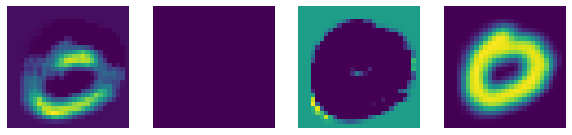

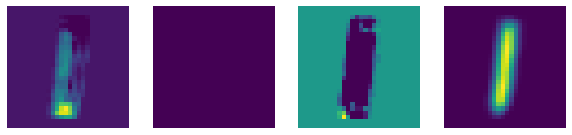

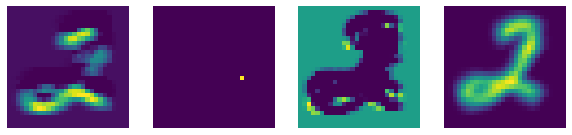

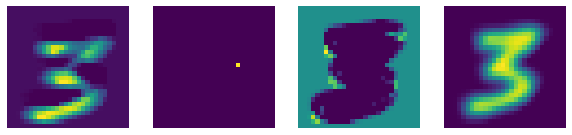

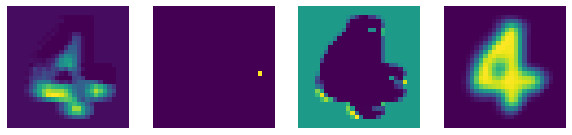

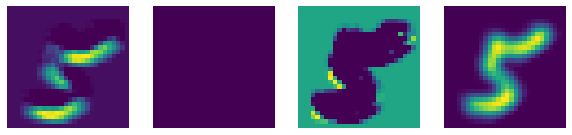

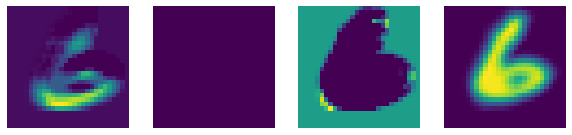

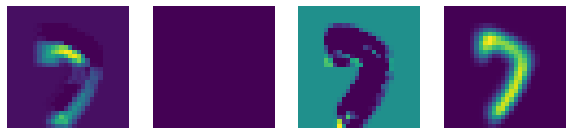

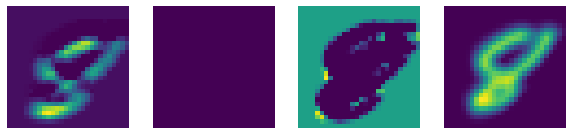

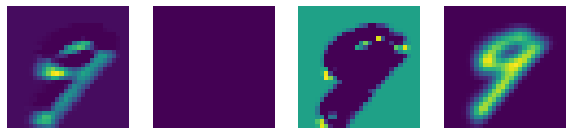

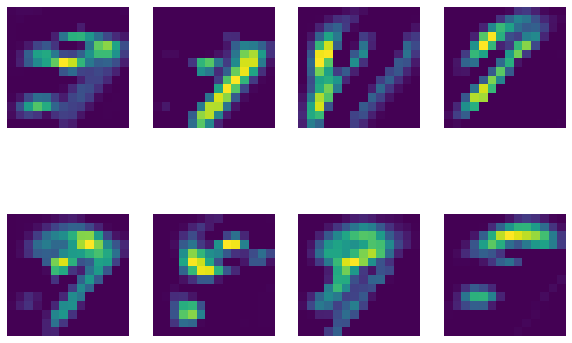

In [23]:
input_numbers=list(input())
print(input_numbers)
batch = next(iter(test_loader))
plt.figure(figsize = (10, 7))
index=1
for i in input_numbers: 
 #   plt.subplot(len(input_numbers)/10+1,10,index)
   # plt.axis('off')
    index+=1
    indx = torch.nonzero(batch[1] == int(i))
    data = batch[0][indx[0]]
    input_x = data.clone().detach().requires_grad_(True)
    input_x = input_x.cuda() if use_cuda else input_x
    output = netR(input_x)
    _, prediction = torch.max(output, 1)
    print(prediction)
    feature_maps = netR.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图
    feature_maps = (feature_maps[0].cpu(), feature_maps[1].cpu()) if use_cuda else feature_maps
    plt.title(i)
 #   plt.imshow(feature_maps[1][0, 3,...].data.numpy())
    #有四个特征图，循环把它们打印出来
    for z in range(4):
        plt.subplot(1,4,z + 1)
        plt.axis('off')
        plt.imshow(feature_maps[0][0, z,...].data.numpy())

    plt.figure(figsize = (10, 7))
    for z in range(8):
        plt.subplot(2,4,z + 1)
        plt.axis('off')
        plt.imshow(feature_maps[1][0, z,...].data.numpy())

D:\Anaconda\envs\test\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([0])
tensor([1])
tensor([2])
tensor([3])
tensor([4])
tensor([5])
tensor([6])
tensor([7])
tensor([8])
tensor([9])


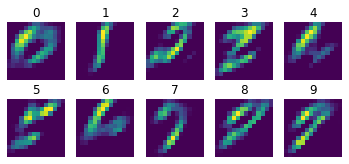

In [24]:
index=1
for i in input_numbers: 
    plt.subplot(len(input_numbers)/5+1,5,index)
    plt.axis('off')
    index+=1
    indx = torch.nonzero(batch[1] == int(i))
    data = batch[0][indx[0]]
    input_x = data.clone().detach().requires_grad_(True)
    input_x = input_x.cuda() if use_cuda else input_x
    output = netR(input_x)
    _, prediction = torch.max(output, 1)
    print(prediction)
    feature_maps = netR.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图
    feature_maps = (feature_maps[0].cpu(), feature_maps[1].cpu()) if use_cuda else feature_maps
    plt.title(i)
    plt.imshow(feature_maps[1][0, 3,...].data.numpy())